**optoSTING results - Figure 4 - Prediction of c-di-GMP/IFN diffusion systems**

March 4th, 2022

*Experimental settings*

    - c-di-GMP sender (opto): pIRF3-GFP, pIRF3-ISRE-mCherry
    
    - c-di-GMP receiver / IFN sender: pIRF3-mCherry
    
    - IFN receiver: ISRE-GFP
    
    - Light condition: 3h

# Imports

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io
from tqdm.notebook import tqdm
from scipy.ndimage import center_of_mass
import ipyparallel as ipp
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from skimage.measure import regionprops_table, label, regionprops
from skimage.transform import resize, downscale_local_mean, rescale
from sklearn.svm import SVC
from skimage.segmentation import find_boundaries
from ast import literal_eval
import numba as nb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import pearsonr
from plotstyle import save_fig, defaultStyle

%matplotlib inline

seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
raw_img_path = lambda group: "../data/cdn_ifn_three_cell/%s/original"%group

# Utils

## Display segmentation

In [2]:
def show_seg(seg_file, img_file=None, ax=None, region=None, adjust=5, chan=0):
    # Input file is the segmentation output of *Cellpose*
    # No return. Show segmentation image
    try:
        seg_data = np.load(seg_file, allow_pickle=True).item()
        outlines = seg_data["outlines"]
    except ValueError:
        outlines = find_boundaries(np.load(seg_file))
    if img_file is None:
        img = seg_data["img"]
    else:
        img = skimage.io.imread(img_file)
    if region is None:
        region = [0, img.shape[0], 0, img.shape[1]]
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
    im_cut = img[region[0]:region[1], region[2]:region[3]]
    outline_cut = outlines[region[0]:region[1], region[2]:region[3]]
    im_cut = im_cut / np.max(im_cut) * adjust
    im_rgb = np.zeros((im_cut.shape[0], im_cut.shape[1], 3))
    im_rgb[:, :, chan] = im_cut
    im_rgb[outline_cut > 0] = 0.8
    ax.imshow(im_rgb)
    ax.axis("off")
    
def show_seg_composite(seg_file_1, seg_file_2, ax=None, region=None, adjust_1=2, adjust_2=5):
    # Input file is the segmentation output of *Cellpose*
    # No return. Show segmentation image
    im_cut_group = []
    outline_cut_group = []
    for seg_file, adjust in zip([seg_file_1, seg_file_2], [adjust_1, adjust_2]):
        seg_data = np.load(seg_file, allow_pickle=True).item()
        outlines, img = seg_data["outlines"], seg_data["img"]
        if region is None:
            region = [0, seg_data["img"].shape[0], 0, seg_data["img"].shape[1]]
        print("Number of cells: %d"%np.max(outlines))
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(10, 10))
        im_cut = img[region[0]:region[1], region[2]:region[3]]
        outline_cut = outlines[region[0]:region[1], region[2]:region[3]]
        im_cut = im_cut / np.max(im_cut) * adjust
        im_cut_group.append(im_cut)     
        outline_cut_group.append(outline_cut)
    im_rgb = np.zeros((im_cut.shape[0], im_cut.shape[1], 3))
    im_rgb[:, :, 0] = im_cut_group[0]
    im_rgb[:, :, 1] = im_cut_group[1]
    im_rgb[:, :, 0][outline_cut_group[0] > 0] = 0.7 
    im_rgb[:, :, 1][outline_cut_group[1] > 0] = 0.7
    ax.imshow(im_rgb)
    ax.axis("off")

## Extract information from labelled image

In [3]:
def mean_intensity_of_max_n_pixels(intensity_im, n=16):
    intensity_arr = intensity_im.flatten()
    if len(intensity_arr) >= n:
        return np.mean(intensity_arr[np.argsort(intensity_arr)[-n:]])
    else:
        return np.mean(intensity_arr)
    
    
def extract_fl_loc(seg_file, img_file):
    try:
        seg_data = np.load(seg_file, allow_pickle=True).item()
        masks = seg_data["masks"]
    except ValueError:
        masks = np.load(seg_file)
    img = skimage.io.imread(img_file)
    return regionprops(masks, intensity_image=img)


def extract_fl_loc_table(seg_path):
    imageinfo_group = []
    for chan in ["red", "green"]:
        seg_file = os.path.join(seg_path, "%s.npy"%chan)
        red_img = os.path.join(raw_img_path(group), "red.tif")
        green_img = os.path.join(raw_img_path(group), "green.tif")
        props_red = extract_fl_loc(seg_file, red_img)
        props_green = extract_fl_loc(seg_file, green_img)
        imageinfo_data = np.array(
            [[
                mean_intensity_of_max_n_pixels(props_red[i].intensity_image),
                mean_intensity_of_max_n_pixels(props_green[i].intensity_image),
                props_red[i].max_intensity,
                props_green[i].max_intensity,
                props_red[i].centroid,
                props_red[i].perimeter,
                props_red[i].area,
                props_red[i].eccentricity,
                i+1
            ] for i in range(len(props_red))], dtype=object)    
        imageinfo_df = pd.DataFrame(imageinfo_data, columns=['red_fl', 'green_fl', 'max_red_fl', 'max_green_fl', 'loc', 'perimeter', 'area', 'eccentricity', 'label'])
        imageinfo_df['chan'] = chan
        imageinfo_group.append(imageinfo_df)
    imageinfo_df = pd.concat(imageinfo_group).reset_index(drop=True)
    return imageinfo_df

# Show segmented image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 26760
Number of cells: 14982
Saving figure cdn_ifn_segmentation


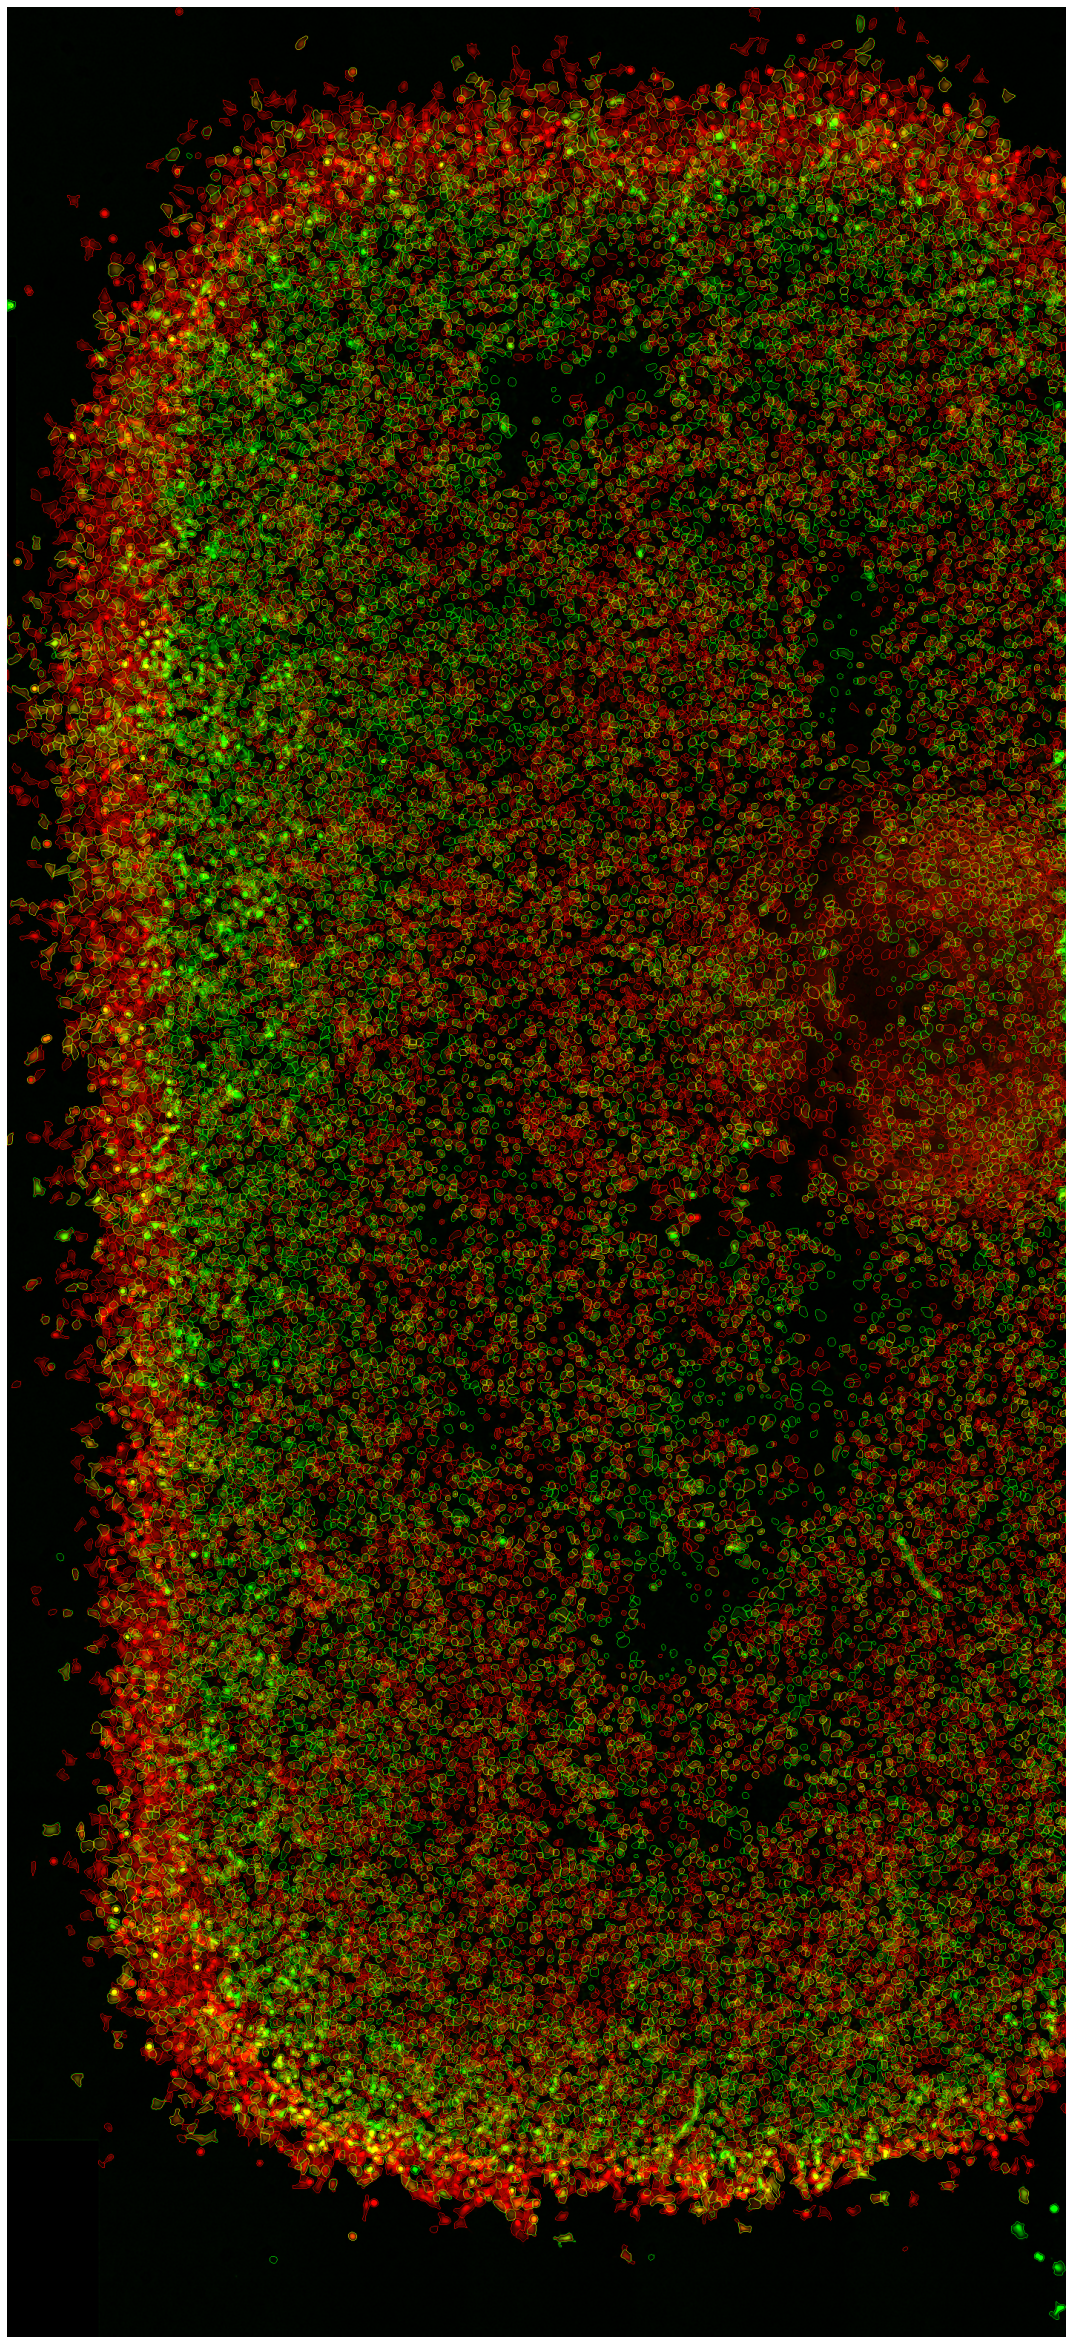

In [15]:
group = '3h'
region = None # [200, 400, 200, 400]
fs = (5, 5)
_, ax = plt.subplots(1, 1, figsize=(15, 40))
plt.subplots_adjust(hspace=0)
# show_seg(seg_file=os.path.join(seg_output_path(group), "red.npy"), ax=ax[0], region=region, adjust=1)
# show_seg(seg_file=os.path.join(seg_output_path(group), "green.npy"), ax=ax[1], region=region, chan=1, adjust=1)
show_seg_composite(
    seg_file_1=os.path.join(seg_output_path(group), "red.npy"),
    seg_file_2=os.path.join(seg_output_path(group), "green.npy") ,
    ax=ax,
    region=region
)
save_fig("cdn_ifn_segmentation")

# Extract fluorescence from red and green channel

In [61]:
%%time

group = "3h"
imageinfo_df = extract_fl_loc_table("../data/cdn_ifn_three_cell/%s/seg"%group)
scaler = MinMaxScaler((1e-1, 1))
imageinfo_df.red_fl = imageinfo_df.red_fl.apply(lambda x: np.log(np.float64(x)))
imageinfo_df.green_fl = imageinfo_df.green_fl.apply(lambda x: np.log(np.float64(x)))
scaler.fit(np.array(imageinfo_df.red_fl).reshape(-1, 1))
imageinfo_df["red_norm"] = scaler.transform(np.array(imageinfo_df.red_fl).reshape(-1, 1))
imageinfo_df["green_norm"] = scaler.transform(np.array(imageinfo_df.green_fl).reshape(-1, 1))
imageinfo_df["roundness"] = 4 * np.pi * imageinfo_df.area / (imageinfo_df.perimeter**2)
imageinfo_df.to_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "imageinfo.csv"), index=False)

imageinfo_df_2 = extract_fl_loc_table("../data/cdn_ifn_three_cell/%s/seg_2"%group)
imageinfo_df_2.red_fl = imageinfo_df_2.red_fl.apply(lambda x: np.log(np.float64(x)))
imageinfo_df_2.green_fl = imageinfo_df_2.green_fl.apply(lambda x: np.log(np.float64(x)))
imageinfo_df_2["red_norm"] = scaler.transform(np.array(imageinfo_df_2.red_fl).reshape(-1, 1))
imageinfo_df_2["green_norm"] = scaler.transform(np.array(imageinfo_df_2.green_fl).reshape(-1, 1))
imageinfo_df_2["roundness"] = 4 * np.pi * imageinfo_df_2.area / (imageinfo_df_2.perimeter**2)
imageinfo_df_2.to_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg_2"%group, "imageinfo.csv"), index=False)

CPU times: user 19.2 s, sys: 496 ms, total: 19.7 s
Wall time: 19.8 s


In [65]:
imageinfo_df.area.mean()

84.73046332231326

# **Classify cells as either sender or receiver**

Use a linear SVM classifier to identify cell class

## Train SVM model with Gaussian-RBF kernel

In [40]:
%matplotlib inline

group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg_2"%group
imageinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "imageinfo.csv"))

X = np.array(imageinfo_df[["red_norm", "green_norm"]])
y = np.array(imageinfo_df.chan == "red", dtype=int)
clf = SVC(C=1, gamma='auto', class_weight={1: 1, 0: 6})
%time clf.fit(X, y)

CPU times: user 17.4 s, sys: 36 ms, total: 17.4 s
Wall time: 17.4 s


SVC(C=1, class_weight={0: 6, 1: 1}, gamma='auto')

## Show classification result on the training set

CPU times: user 13.5 s, sys: 0 ns, total: 13.5 s
Wall time: 13.5 s
Saving figure cdn_ifn_classify_sender_receiver


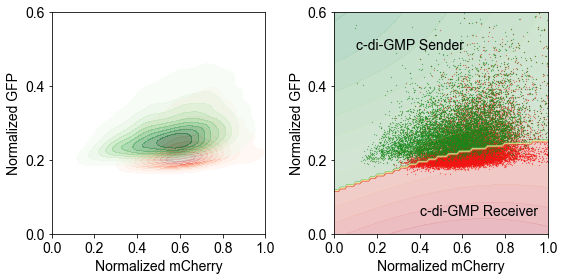

In [41]:
def plot_predictions(clf, axes, ax):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    ax.contourf(x0, x1, y_pred, cmap=plt.cm.RdYlGn_r, alpha=0.2, levels=16)
    ax.contourf(x0, x1, y_decision, cmap=plt.cm.RdYlGn_r, alpha=0.1, levels=16)

defaultStyle()
_, ax = plt.subplots(1, 2, figsize=(8, 4))
# sns.scatterplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], color="r", s=1, ax=ax[0])
# sns.scatterplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], color="g", s=1, ax=ax[0])
sns.kdeplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], cmap="Reds", ax=ax[0], fill=True, alpha=0.5)
sns.kdeplot(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], cmap="Greens", ax=ax[0], fill=True, alpha=0.5)

ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], color="r", s=0.05)
ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], color="g", s=0.05)
ax[1].text(0.1, 0.5, "c-di-GMP Sender", color="k", fontsize=14)
ax[1].text(0.4, 0.05, "c-di-GMP Receiver", color="k", fontsize=14)
for a in ax:
    a.set_xlabel("Normalized mCherry")
    a.set_ylabel("Normalized GFP")
    a.axis([0, 1, 0, 0.6])
    a.set_yticks([0, 0.2, 0.4, 0.6])

%time plot_predictions(clf, axes=[0, 1, 0, 0.7], ax=ax[1])
save_fig("cdn_ifn_classify_sender_receiver")

## Apply the SVM model to the complete dataset

In [ ]:
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
imageinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "imageinfo.csv"))
_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(x="red_norm", y="green_norm", data=imageinfo_df, color="gray", s=0.05)
ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="red"], color="r", s=0.05)
ax[1].scatter(x="red_norm", y="green_norm", data=imageinfo_df[imageinfo_df.chan=="green"], color="g", s=0.05)
for a in ax:
    a.set_xlabel("mCherry intensity")
    a.set_ylabel("GFP intensity")
plot_predictions(clf, axes=[0, 1, 0, 0.7], ax=ax[1])

In [37]:
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
imageinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "imageinfo.csv"))
%time imageinfo_df['cell_class'] = clf.predict(np.array(imageinfo_df[['red_norm', 'green_norm']]))
print("Green: %d"%(imageinfo_df.cell_class==0).sum())
print("Red: %d"%((imageinfo_df.cell_class==1)).sum())
imageinfo_df.to_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "imageinfo.csv"), index=False)

CPU times: user 27.5 s, sys: 0 ns, total: 27.5 s
Wall time: 27.5 s
Green: 28415
Red: 13327


# Remove overlapping segmentation

In [ ]:
group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
red_seg_data = np.load(os.path.join(seg_output_path(group), "red.npy"), allow_pickle=True).item()["masks"]
green_seg_data = np.load(os.path.join(seg_output_path(group), "green.npy"), allow_pickle=True).item()["masks"]
seg_data = {"red": red_seg_data, "green": green_seg_data}
sender_seg_data = np.zeros_like(red_seg_data)
receiver_seg_data = np.zeros_like(green_seg_data)
imageinfo_df = pd.read_csv(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "imageinfo.csv"))

sender_label = 1
receiver_label = 1
for i in tqdm(imageinfo_df.index):
    cell_class, chan, label = tuple(imageinfo_df.loc[i, ["cell_class", "chan", "label"]])
    if cell_class == 1:
        if (receiver_seg_data & (seg_data[chan]==label)).sum() >= (seg_data[chan]==label).sum() * 0.5:
            continue
        else:
            receiver_seg_data[seg_data[chan]==label] = receiver_label
            receiver_label += 1
    elif cell_class == 0:
        if (sender_seg_data & (seg_data[chan]==label)).sum() >= (seg_data[chan]==label).sum() * 0.5:
            continue
        else:
            sender_seg_data[seg_data[chan]==label] = sender_label
            sender_label += 1

np.save(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "sender_seg.npy"), sender_seg_data)
np.save(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "receiver_seg.npy"), receiver_seg_data)

Sender: 24594
Receiver: 12590
Saving figure cdn_ifn_cleaned_segmentation


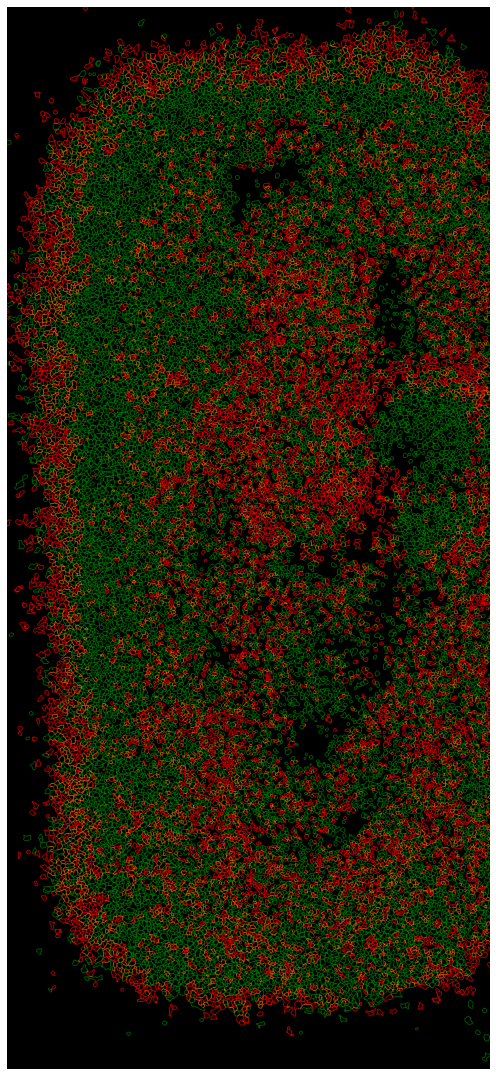

In [29]:
sender_seg_data = np.load(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "sender_seg.npy"))
receiver_seg_data = np.load(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "receiver_seg.npy"))
print("Sender: %d"%(np.max(sender_seg_data)))
print("Receiver: %d"%(np.max(receiver_seg_data)))
_, ax = plt.subplots(1, 1, figsize=(7, 20))
outline_im = np.zeros((sender_seg_data.shape[0], sender_seg_data.shape[1], 3))
outline_im[:, :, 1] = find_boundaries(sender_seg_data) * 0.5
outline_im[:, :, 0] = find_boundaries(receiver_seg_data)
ax.imshow(outline_im)
ax.axis("off")
save_fig("cdn_ifn_cleaned_segmentation")

# Re-extract fluorescence and locations of sender and receiver

In [52]:
group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
senderprops = extract_fl_loc(os.path.join(seg_output_path(group), "sender_seg.npy"), os.path.join(raw_img_path(group), "green.tif"))
receiverprops = extract_fl_loc(os.path.join(seg_output_path(group), "receiver_seg.npy"), os.path.join(raw_img_path(group), "red.tif"))

senderinfo = np.array(
    [[
        mean_intensity_of_max_n_pixels(senderprops[i].intensity_image, n=16),
        senderprops[i].centroid,
        i+1
    ] for i in range(len(senderprops))], dtype=object)
receiverinfo = np.array(
    [[
        mean_intensity_of_max_n_pixels(receiverprops[i].intensity_image, n=16),
        receiverprops[i].centroid,
        i+1
    ] for i in range(len(receiverprops))], dtype=object)
senderinfo_df = pd.DataFrame(senderinfo, columns=['fl', 'loc', 'label'])
senderinfo_df['cell_class'] = 'sender'
receiverinfo_df = pd.DataFrame(receiverinfo, columns=['fl', 'loc', 'label'])
receiverinfo_df['cell_class'] = 'receiver'
srinfo_df = senderinfo_df.append(receiverinfo_df, ignore_index=True).reset_index(drop=True)
srinfo_df.to_csv(os.path.join(seg_output_path(group), "srinfo.csv"), index=False)

# Determine the activation threshold

## Fluorescence distribution

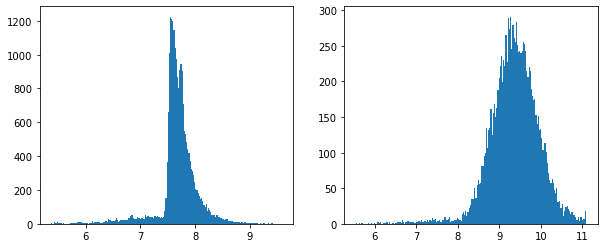

In [53]:
group = "3h"
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
srinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "srinfo.csv"))
srinfo_df['log_fl'] = srinfo_df.fl.apply(np.log)
_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(srinfo_df[srinfo_df.cell_class == "sender"].log_fl, bins=200);
# ax[0].set_xlim([0, 5000])
ax[1].hist(srinfo_df[srinfo_df.cell_class == "receiver"].log_fl, bins=200);
# ax[1].set_xlim([8, 12]);

## Annotate intensity on the image

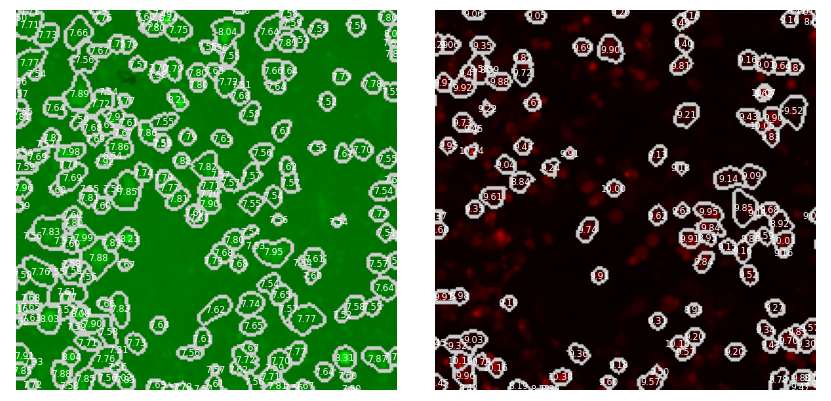

In [55]:
def show_intensity_annotation(seg_file, img_file, region, ax=None):
    try:
        masks = np.load(seg_file, allow_pickle=True).item()['masks'][region[0]:region[1], region[2]:region[3]]
    except ValueError:
        masks = np.load(seg_file)[region[0]:region[1], region[2]:region[3]]
    img = skimage.io.imread(img_file)[region[0]:region[1], region[2]:region[3]]
    props = regionprops(masks, intensity_image=img)
    for p in props:
        ax.text(
            x=p.centroid[1], 
            y=p.centroid[0], 
            s=str("%.2f"%(np.log(mean_intensity_of_max_n_pixels(p.intensity_image, 5)))),
            color="white",
            ha="center",
            va="center",
            fontsize=9
        )
        
        
group = '3h'
seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
window_size = 200
startx, starty = 1500, 500
region = [startx, startx+window_size, starty, starty+window_size]
_, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.subplots_adjust(wspace=0)

seg_file = os.path.join(seg_output_path(group), "sender_seg.npy")
img_file = os.path.join(raw_img_path(group), "green.tif")
show_seg(seg_file=seg_file, img_file=img_file, ax=ax[0], region=region, adjust=1, chan=1)
show_intensity_annotation(seg_file=seg_file, img_file=img_file, ax=ax[0], region=region)

seg_file = os.path.join(seg_output_path(group), "receiver_seg.npy")
img_file = os.path.join(raw_img_path(group), "red.tif")
show_seg(seg_file=seg_file, img_file=img_file, ax=ax[1], region=region, adjust=1, chan=0)
show_intensity_annotation(seg_file=seg_file, img_file=img_file, ax=ax[1], region=region)

## Activation threshold

In [268]:
sender_thresh = 7.51
receiver_thresh = 9.72False

# Prediction of receiver activation based on *ReLU* model

## Calculate sender activation ratio in the neighborhood

In [269]:
def distance(loc1, loc2):
    return np.sqrt(((np.array(loc1) - np.array(loc2))**2).sum())


group = "3h"
cell_diameter = 8
kernel_size = 4
neighborhood = 60 # kernel_size * cell_diameter

seg_output_path = lambda group: "../data/cdn_ifn_three_cell/%s/seg"%group
srinfo_df = pd.read_csv(os.path.join(seg_output_path(group), "srinfo.csv"))

srinfo_df['loc'] = srinfo_df['loc'].apply(literal_eval)
srinfo_df['log_fl'] = srinfo_df.fl.apply(np.log)
srinfo_df['activation'] = ((srinfo_df.log_fl > sender_thresh) & (srinfo_df.cell_class == "sender")) | ((srinfo_df.log_fl > receiver_thresh) & (srinfo_df.cell_class == "receiver"))

print("Sender activation ratio: %.2f%%"%(100*((srinfo_df.cell_class == "sender") & (srinfo_df.log_fl > sender_thresh)).sum() / (srinfo_df.cell_class == "sender").sum()))
print("Receiver activation ratio: %.2f%%"%(100*((srinfo_df.cell_class == "receiver") & (srinfo_df.log_fl > receiver_thresh)).sum() / (srinfo_df.cell_class == "receiver").sum()))

sender_df = srinfo_df[srinfo_df.cell_class == "sender"].reset_index(drop=True)
receiver_df = srinfo_df[srinfo_df.cell_class == "receiver"].reset_index(drop=True)
receiver_df["x"] = receiver_df['loc'].apply(lambda x: x[0])
receiver_df["y"] = receiver_df['loc'].apply(lambda x: x[1])
sender_df["x"] = sender_df['loc'].apply(lambda x: x[0])
sender_df["y"] = sender_df['loc'].apply(lambda x: x[1])

for i in tqdm(receiver_df.index):
    x0 = receiver_df.loc[i, 'x']
    y0 = receiver_df.loc[i, 'y']
    neighbor_sender_df = sender_df[(sender_df.x > x0 - neighborhood) & (sender_df.x < x0 + neighborhood) & (sender_df.y > y0 - neighborhood) & (sender_df.y < y0 + neighborhood)]
    neighboring_sender_activ_arr = neighbor_sender_df[neighbor_sender_df['loc'].apply(lambda x: distance(x, [x0, y0])) <= neighborhood].activation
    nSender = len(neighboring_sender_activ_arr)
    if nSender==0:
        receiver_df.loc[i, 'fs'] = 0
    else:
        neighboring_sender_activ_ratio = neighboring_sender_activ_arr.sum() / len(neighboring_sender_activ_arr)
        receiver_df.loc[i, 'fs'] = neighboring_sender_activ_ratio

Sender activation ratio: 87.26%
Receiver activation ratio: 24.99%


  0%|          | 0/12505 [00:00<?, ?it/s]

## Prediction

In [270]:
tp = 0.85

def relu(x, tp):
    return (x > tp) * 1 / (1 - tp) * (x - tp)


def linear(x, tp):
    x_half = tp + (1 - tp) / 2
    return 1 / 2 / x_half * x


def sigmoid(x, tp, n=10):
    x_half = tp + (1 - tp) / 2
    return x ** n / (x_half ** n + x ** n)

receiver_df.dropna(inplace=True)
receiver_df['activ_score'] = receiver_df.fs.apply(lambda x: relu(x, tp))
receiver_df['activ_pred'] = receiver_df.activ_score.apply(lambda x: x > 0.5)
receiver_df['activ_pred_stochastic'] = receiver_df.activ_score.apply(lambda x: np.random.uniform() < x)
print(classification_report(receiver_df.activation, receiver_df.activ_pred_stochastic))
print(confusion_matrix(receiver_df.activation, receiver_df.activ_pred_stochastic))

              precision    recall  f1-score   support

       False       0.80      0.81      0.80      9380
        True       0.40      0.38      0.39      3125

    accuracy                           0.70     12505
   macro avg       0.60      0.59      0.59     12505
weighted avg       0.70      0.70      0.70     12505

[[7574 1806]
 [1942 1183]]


In [263]:
receiver_df.activ_pred_stochastic.sum(), receiver_df.activation.sum()

(3062, 3194)

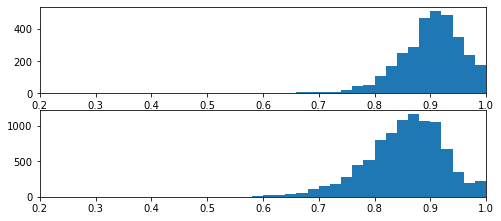

In [264]:
_, ax = plt.subplots(2, 1, figsize=(8, 3.5))
ax[0].hist(receiver_df[receiver_df.activation].fs, bins=50)
ax[1].hist(receiver_df[np.logical_not(receiver_df.activation)].fs, bins=50);
for axis in ax:
    axis.set_xlim([0.2, 1])

## Display results

Saving figure cdn_ifn_left_prediction_complete


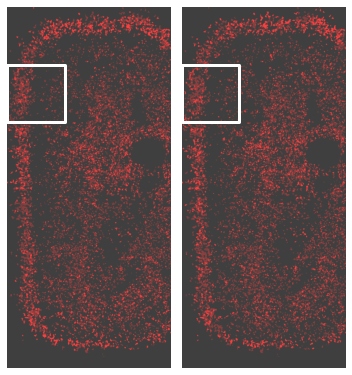

In [265]:
group = "3h"
sender_masks = np.load(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "sender_seg.npy"))
receiver_masks = np.load(os.path.join("../data/cdn_ifn_three_cell/%s/seg"%group, "receiver_seg.npy"))
seg_img = np.zeros((sender_masks.shape[0], sender_masks.shape[1], 3))
sender_binary_masks = np.isin(sender_masks, sender_df[sender_df.activation].label) * 0.5
sender_binary_masks += np.isin(sender_masks, sender_df[np.logical_not(sender_df.activation)].label) * 0.2
receiver_binary_masks = np.isin(receiver_masks, receiver_df[receiver_df.activation].label) * 1.0
receiver_binary_masks += np.isin(receiver_masks, receiver_df[np.logical_not(receiver_df.activation)].label) * 0.4

x0, y0 = 500, 0
window = 500

# seg_img[:, :, 1] = sender_binary_masks
seg_img[:, :, 0] = receiver_binary_masks
# seg_img[:, :, 1][find_boundaries(receiver_masks)] = 1

pred_img = np.zeros((sender_masks.shape[0], sender_masks.shape[1], 3))
pred_sender_binary_masks = np.isin(sender_masks, sender_df[sender_df.activation].label) * 1.0
pred_sender_binary_masks += np.isin(sender_masks, sender_df[np.logical_not(sender_df.activation)].label) * 0.4
pred_receiver_binary_masks = np.isin(receiver_masks, receiver_df[receiver_df.activ_pred_stochastic].label) * 1.0
pred_receiver_binary_masks += np.isin(receiver_masks, receiver_df[np.logical_not(receiver_df.activ_pred_stochastic)].label) * 0.4
# pred_img[:, :, 1] = pred_sender_binary_masks
pred_img[:, :, 0] = pred_receiver_binary_masks

# Groundtruth
_, ax = plt.subplots(1, 2, figsize=(5, 12))
plt.subplots_adjust(wspace=0.05)
ax[0].imshow(seg_img, alpha=0.75)
ax[0].axis('off')

# Prediction
ax[1].imshow(pred_img, alpha=0.75)
ax[1].axis('off')

ax[0].plot([y0, y0, y0+window, y0+window, y0], [x0, x0+window, x0+window, x0, x0], lw=3, c="w")
ax[1].plot([y0, y0, y0+window, y0+window, y0], [x0, x0+window, x0+window, x0, x0], lw=3, c="w")
save_fig("cdn_ifn_left_prediction_complete")

# sender_df.to_csv("../data/cdn_ifn_three_cell/3h/results/sender_sigmoid.csv", index=False)
receiver_df.to_csv("../data/cdn_ifn_three_cell/3h/results/receiver.csv", index=False)

Saving figure cdn_ifn_left_prediction_part


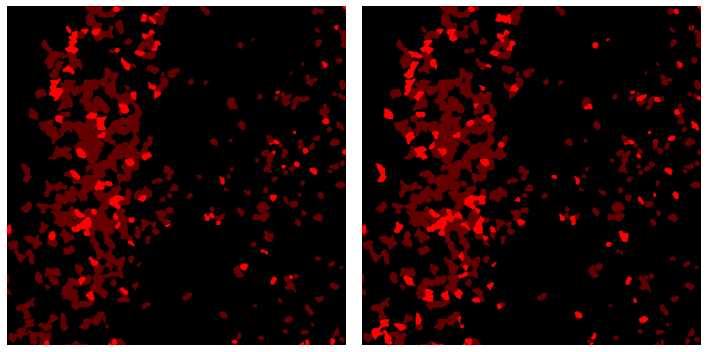

In [266]:
# Groundtruth
# seg_img[find_boundaries(receiver_masks)] = 0.5
# pred_img[find_boundaries(receiver_masks)] = 0.5
# seg_img[:, :, 1] = sender_binary_masks


_, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
ax[0].imshow(seg_img[x0:x0+window, y0:y0+window, :], alpha=1)
ax[0].axis('off')

# Prediction
ax[1].imshow(pred_img[x0:x0+window, y0:y0+window, :], alpha=1)
ax[1].axis('off')
save_fig("cdn_ifn_left_prediction_part")

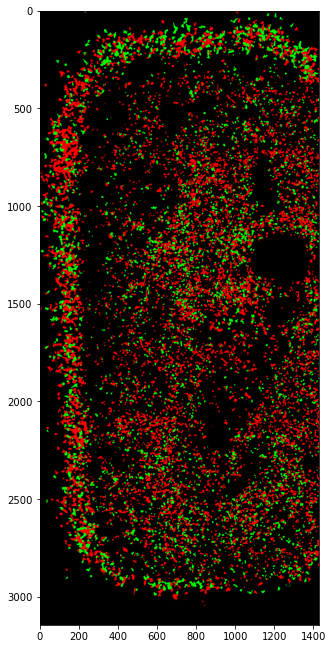

In [267]:
_, ax = plt.subplots(1, 1, figsize=(5, 12))
seg_img = np.zeros((sender_masks.shape[0], sender_masks.shape[1], 3))
seg_img[:, :, 0] = (((receiver_binary_masks==0.4) & (pred_receiver_binary_masks==0.4)) | ((receiver_binary_masks==1) & (pred_receiver_binary_masks==1))).astype(float)
seg_img[:, :, 1] = (((receiver_binary_masks==0.4) & (pred_receiver_binary_masks==1)) | ((receiver_binary_masks==1) & (pred_receiver_binary_masks==0.4))).astype(float)
# seg_img[:, :, 1] = (((receiver_binary_masks==0.4) & (pred_receiver_binary_masks==1)) | ((receiver_binary_masks==1) & (pred_receiver_binary_masks==0.4))).astype(float) * 0.75
ax.imshow(seg_img)

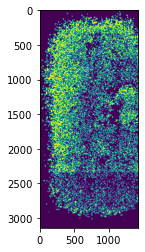

In [132]:
plt.imshow(sender_binary_masks)

# Predicting IFN diffusion

## Downsampling the segmentation masks for c-di-GMP receiver/IFN sender

In [2]:
nGrid = 1200
senders = np.zeros((nGrid, nGrid))
cells = np.zeros((nGrid, nGrid))
receiver_df = pd.read_csv("../data/cdn_ifn_three_cell/3h/results/receiver.csv")
receiver_masks = np.load("../data/cdn_ifn_three_cell/3h/seg/receiver_seg.npy")
receiver_binary_masks = np.isin(receiver_masks, receiver_df[receiver_df.activ_pred_stochastic].label) * 1.0
downscaled_img = (downscale_local_mean(receiver_binary_masks, (5, 5)) > 0.45).astype(int)
print("Downscaled area: %.2f%%"%(100 * downscaled_img.sum() / len(downscaled_img.flatten())))
print("Original area: %.2f%%"%(100 * receiver_binary_masks.sum() / len(receiver_binary_masks.flatten())))
x0 = (nGrid - downscaled_img.shape[0]) // 2
y0 = nGrid // 2 - downscaled_img.shape[1]
senders[x0:x0+downscaled_img.shape[0], y0:y0+downscaled_img.shape[1]] = downscaled_img
senders_control = np.zeros((nGrid, nGrid))
senders_control[:, :nGrid // 2] = 1

Downscaled area: 5.73%
Original area: 5.88%


## Masks of IFN receiver

In [3]:
cells = np.zeros((nGrid, nGrid))
ifn_receiver_masks = np.load("../data/cdn_ifn_three_cell/3h/seg/green_right_half.npy", allow_pickle=True).item()["masks"]
downscaled_ifn_receivers = (downscale_local_mean(ifn_receiver_masks > 0, (5, 5)) > 0.5).astype(int)
print("Downscaled area: %.2f%%"%(100 * downscaled_ifn_receivers.sum() / len(downscaled_ifn_receivers.flatten())))
print("Original area: %.2f%%"%(100 * (ifn_receiver_masks>0).sum() / len(ifn_receiver_masks.flatten())))
xshift = 13
yshift = 0

Downscaled area: 47.00%
Original area: 46.30%


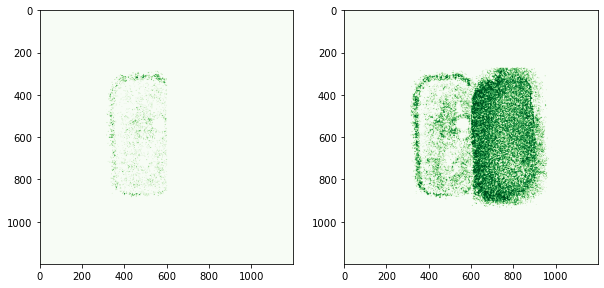

In [4]:
downscaled_cells = (downscale_local_mean(receiver_masks > 0, (5, 5)) > 0.5).astype(int)
cells[x0:x0+downscaled_img.shape[0], y0:y0+downscaled_img.shape[1]] = downscaled_cells
cells[
    (x0-xshift):(x0+downscaled_ifn_receivers.shape[0]-xshift), 
    (y0+downscaled_img.shape[1]-yshift):(y0+downscaled_img.shape[1]+downscaled_ifn_receivers.shape[1]-yshift)
] = downscaled_ifn_receivers
_, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(senders, cmap="Greens")
ax[1].imshow(cells, cmap="Greens")

## Elliptic equation

### Solution

$$D\left(\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2}\right) + A - \gamma u = 0$$

$$D\left(u_{i,j+1}+u_{i,j-1}+u_{i+1,j}+u_{i-1,j}-4u_{i,j}\right) + A - \gamma u_{i,j} = 0$$

In [45]:
%%time
gamma = 2.5e-4
D = 5
a = 1
D_arr = D # * (cells == 0) + D / 5 * (cells > 0)
row_ind = [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + [i for i in range(1, nGrid**2) if not i % nGrid == 0] + list(range(nGrid**2-nGrid)) + list(range(nGrid, nGrid**2))
col_ind = [i for i in range(1, nGrid**2) if not i % nGrid == 0] + [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + list(range(nGrid, nGrid**2)) + list(range(nGrid**2-nGrid))
data = [-1] * (nGrid-1) * nGrid * 2 + [-1] * (nGrid**2*2 - 2*nGrid)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))
A_arr_diag_compensation = np.array(np.sum(A_arr, axis=1)).flatten()
row_ind += list(range(nGrid**2))
col_ind += list(range(nGrid**2))
data += list(np.array([4] * nGrid**2) + (gamma * cells / D_arr).flatten() - A_arr_diag_compensation - 4)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))
b = a * (senders / D_arr).flatten()
result_ss = spsolve(A_arr, b)

CPU times: user 1min 38s, sys: 1.08 s, total: 1min 39s
Wall time: 15.9 s


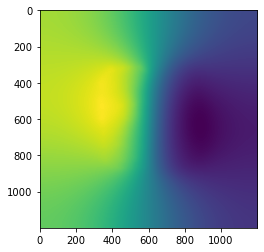

In [40]:
plt.imshow(result_ss.reshape((nGrid, nGrid)))

### Convert IFN to fluorescent intensity

0.7288579654446286


(0.0, 1.0, 0.0, 1.0)

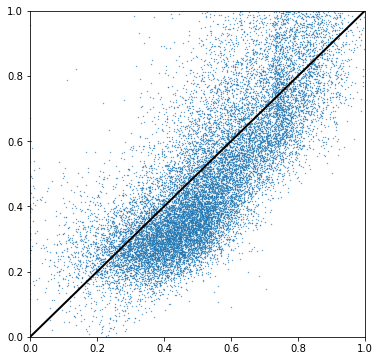

In [41]:
result_im = result_ss.reshape((nGrid, nGrid)) * cells
result_im_crop = result_im[
    (x0-xshift):(x0+downscaled_ifn_receivers.shape[0]-xshift), 
    (y0+downscaled_img.shape[1]-yshift):(y0+downscaled_img.shape[1]+downscaled_ifn_receivers.shape[1]-yshift)
]
ifn_receiver_im = skimage.io.imread("../data/cdn_ifn_three_cell/3h/right_half/green.tif")
result_im_crop = resize(result_im_crop, ifn_receiver_im.shape)

pred_props = regionprops(ifn_receiver_masks, intensity_image=result_im_crop)
true_props = regionprops(ifn_receiver_masks, intensity_image=ifn_receiver_im)
# true_intensity = np.array([p.mean_intensity for p in true_props])
# pred_intensity = np.array([p.mean_intensity for p in pred_props])
true_intensity = np.array([mean_intensity_of_max_n_pixels(p.intensity_image, 200) for p in true_props])
pred_intensity = np.array([mean_intensity_of_max_n_pixels(p.intensity_image, 200) for p in pred_props])
locations_x = np.array([p.centroid[0] for p in true_props])
locations_y = np.array([p.centroid[1] for p in true_props])
ifn_to_intensity = lambda x: x / (x + 600) 
# pred_intensity = ifn_to_intensity(pred_intensity)


true_intensity = (true_intensity - true_intensity.min()) / (true_intensity.max() - true_intensity.min()) * 5 - 0.2
pred_intensity = (pred_intensity - pred_intensity.min()) / (pred_intensity.max() - pred_intensity.min())

print(pearsonr(pred_intensity, true_intensity)[0])

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(pred_intensity, true_intensity, s=0.1)
ax.plot([0, 1], [0, 1], lw=2, c='k')
ax.axis([0, 1, 0, 1])

<ErrorbarContainer object of 3 artists>

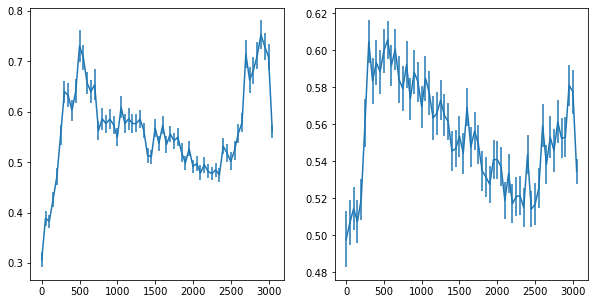

In [42]:
loc_bins =  np.arange(0, 3100, 50)
loc_digit = np.digitize(locations_x, loc_bins)
true_intensity_binned = np.array([[np.mean(true_intensity[loc_digit==i]), np.std(true_intensity[loc_digit==i]) / np.sqrt((loc_digit==i).sum())] for i in range(1, loc_digit.max()+1)])
pred_intensity_binned = np.array([[np.mean(pred_intensity[loc_digit==i]), np.std(pred_intensity[loc_digit==i]) / np.sqrt((loc_digit==i).sum())] for i in range(1, loc_digit.max()+1)])

_, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].scatter(locations_x, true_intensity, s=0.01)
ax[0].errorbar(loc_bins, true_intensity_binned[:, 0], true_intensity_binned[:, 1])
# ax[0].set_ylim([0.04, 0.225])
# ax[1].scatter(locations_x, pred_intensity, s=0.01)
ax[1].errorbar(loc_bins, pred_intensity_binned[:, 0], pred_intensity_binned[:, 1])
# ax[1].set_ylim([0.35, 0.6])

<ErrorbarContainer object of 3 artists>

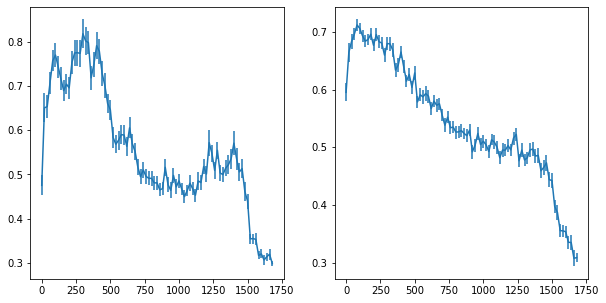

In [43]:
loc_bins =  np.arange(0, 1700, 20)
loc_digit = np.digitize(locations_y, loc_bins)
true_intensity_binned = np.array([[np.mean(true_intensity[loc_digit==i]), np.std(true_intensity[loc_digit==i]) / np.sqrt((loc_digit==i).sum())] for i in range(1, loc_digit.max()+1)])
pred_intensity_binned = np.array([[np.mean(pred_intensity[loc_digit==i]), np.std(pred_intensity[loc_digit==i]) / np.sqrt((loc_digit==i).sum())] for i in range(1, loc_digit.max()+1)])

_, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].scatter(locations_y, true_intensity, s=0.01)
ax[0].errorbar(loc_bins, true_intensity_binned[:, 0], true_intensity_binned[:, 1])
# ax[0].set_ylim([0.1, 0.3])
# ax[1].scatter(locations_y, pred_intensity, s=0.01)
ax[1].errorbar(loc_bins, pred_intensity_binned[:, 0], pred_intensity_binned[:, 1])
# ax[1].set_ylim([0.3, 1])

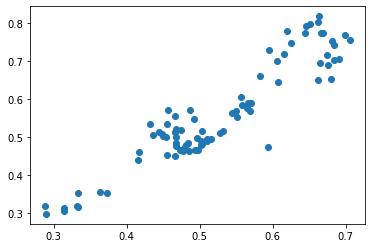

In [31]:
plt.scatter(pred_intensity_binned[:, 0], true_intensity_binned[:, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


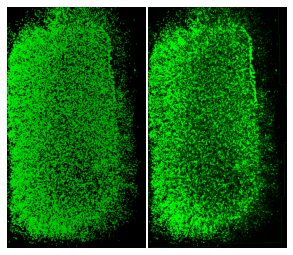

In [51]:
_, ax = plt.subplots(1, 2, figsize=(5, 5))
plt.subplots_adjust(wspace=0.02)
result_im_crop_convert = result_im_crop / result_im_crop.max()
# result_im_crop_convert = (result_im_crop_convert) / (result_im_crop_convert + 0.75)
result_im_crop_rgb = np.zeros((result_im_crop.shape[0], result_im_crop.shape[1], 3))
result_im_crop_rgb[:, :, 1] = result_im_crop_convert
# result_im_crop_rgb[find_boundaries(ifn_receiver_masks)] = 1

ifn_receiver_im = skimage.io.imread("../data/cdn_ifn_three_cell/3h/processed/green_right_half.tif")
ifn_receiver_rgb = np.zeros((ifn_receiver_im.shape[0], ifn_receiver_im.shape[1], 3))
ifn_receiver_rgb[:, :, 1] = ifn_receiver_im / ifn_receiver_im.max()
# ifn_receiver_rgb[find_boundaries(ifn_receiver_masks)] = 1
ax[0].imshow(result_im_crop_rgb) # , "Greens")
ax[1].imshow(ifn_receiver_rgb * 20) #, "Greens")
for a in ax: 
    a.axis('off')